In [1]:
import sys
sys.path.append('../../code')
import os
import qPCR_analysis_functions as qf
import math
%matplotlib inline
resdflist=[]
ampdflist=[]
fnamelist=[]
platename='NA'
flist=os.listdir('..')
flist.sort()
for i in range(len(flist)):
    if(flist[i].endswith('.eds')):
        fnamelist.append(flist[i])
        resdf,ampdf,header=qf.getEDSData('../'+flist[i])
        if(platename=='NA'): platename=header['Description']
        if(platename=='NA'): platename=header['Comment']
        if(platename=='NA'): platename=header['Barcode']
        if(platename=='NA'): platename=header['Name']
        resdflist.append(resdf)
        ampdflist.append(ampdf)
print('plate name = '+platename)
resdflist[0].head()

(84, 39)
plate name = PTS303KKN_Plate_1


,Well,Well Position,Sample,Target,Task,Cq,Avg Cq,Cq SD,Delta Cq,Qty,Avg Qty,Qty SD,Amp Status
0,0,A1,NTC,N1,NTC,NaN,,,,,,,-1
1,1,A2,NTC,N2,NTC,NaN,,,,,,,-1
2,2,A3,NTC,RP,NTC,NaN,,,,,,,-1
3,3,A4,CFHRDWNSS,N1,Target,NaN,,,,,,,-1
4,4,A5,CFHRDWNSS,N2,Target,NaN,,,,,,,-1


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
resdf,uampdf=qf.aggregate96WellData(resdflist,ampdflist)
#need to add a cycle number column to the uampdf for later
uampdf['Cycle Number']=range(1,(len(uampdf)+1))
resdf.tail()

,Well,Well Position,Sample,Target,Task,Cq,Avg Cq,Cq SD,Delta Cq,Qty,Avg Qty,Qty SD,Amp Status
79,91,H8,Chemagen NTC,N2,NTC,NaN,,,,,,,-1
80,92,H9,Chemagen NTC,RP,NTC,NaN,,,,,,,-1
81,93,H10,RPE1_1,N1,Target,NaN,,,,,,,-1
82,94,H11,RPE1_1,N2,Target,NaN,,,,,,,-1
83,95,H12,RPE1_1,RP,Target,30.608831,30.608831,,,,,,1


In [4]:
#at this point we can proceed as though we have a 384 well plate; sample names (could be specimen id's) will get carried as usual
#now we can make our heatmap
qf.transformResDF(resdf)
resdf.head()

,Well,Well Position,Sample,Target,Task,Cq,Avg Cq,Cq SD,Delta Cq,Qty,Avg Qty,Qty SD,Amp Status,row,col,rowlett
0,0,A1,NTC,N1,NTC,NaN,,,,,,,-1,1,1,A
1,1,A2,NTC,N2,NTC,NaN,,,,,,,-1,1,2,A
2,2,A3,NTC,RP,NTC,NaN,,,,,,,-1,1,3,A
3,3,A4,CFHRDWNSS,N1,Target,NaN,,,,,,,-1,1,4,A
4,4,A5,CFHRDWNSS,N2,Target,NaN,,,,,,,-1,1,5,A


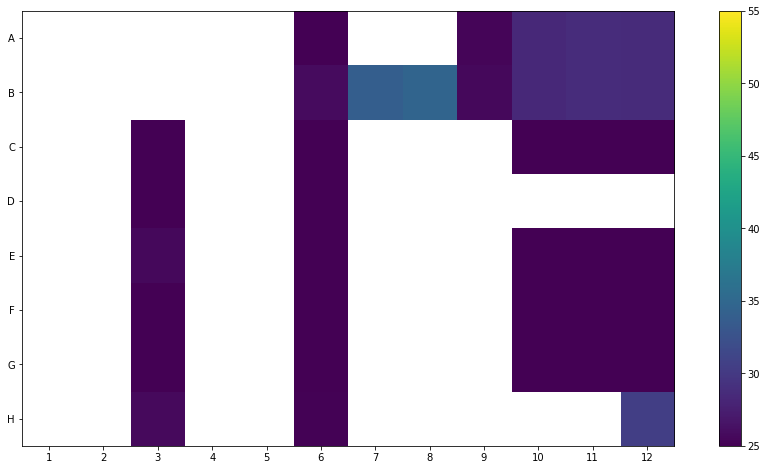

In [5]:
qf.makeHeatMap(resdf,'Cq')

In [6]:
#now lets make a big plot matrix with all of the amplification curves
#first need to make an array where rows are cycle and columns are deltaRn
mincycle=min(uampdf['Cycle Number'])
maxcycle=max(uampdf['Cycle Number'])
minamp=0.0
maxamp=0.0
for column in uampdf.columns:
    if(column!='Cycle Number'):
        minamp=min(minamp,min(uampdf[column]))
        maxamp=max(maxamp,max(uampdf[column]))
print([mincycle,maxcycle,minamp,maxamp])

[1, 39, -0.04573885, 4.6802529999999996]


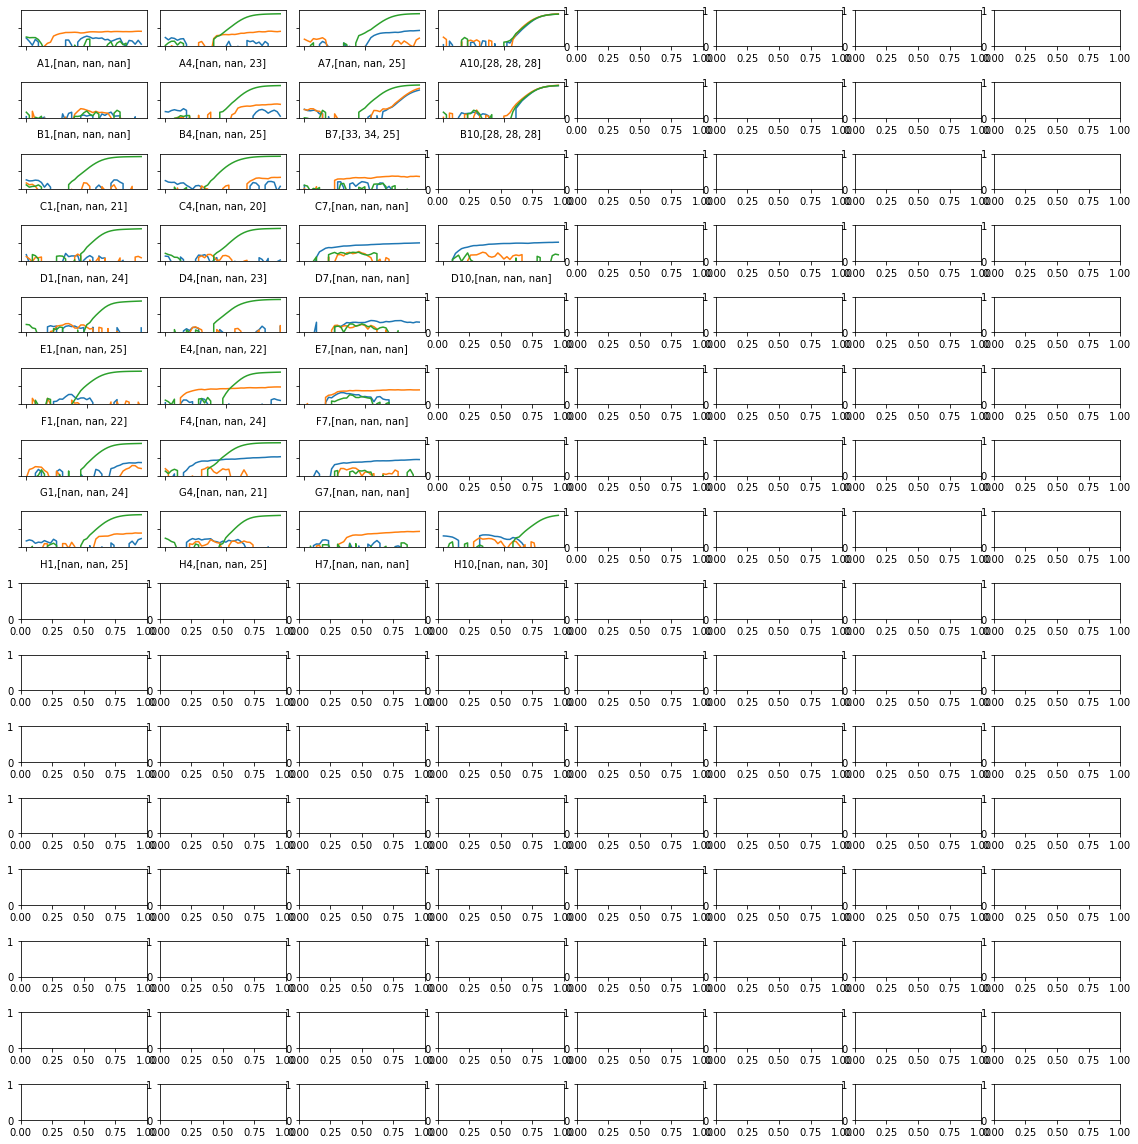

In [7]:
#now make the big matplotlib composite
qf.getPlotGrid(resdf,uampdf,maxamp,True)

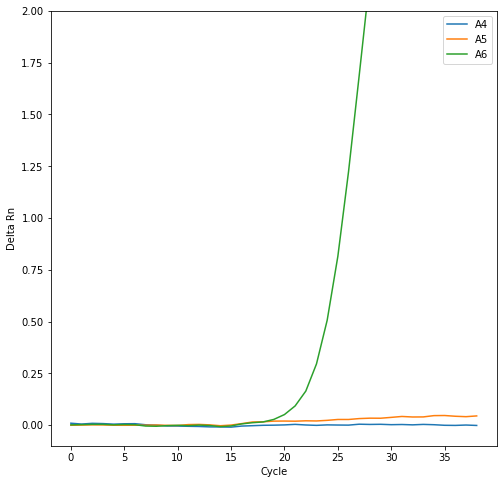

In [8]:
#select out triples to plot
qf.getTriplePlot('A4',uampdf,2.0)

In [9]:
outresdf,uampdf=qf.fitDF(uampdf,resdf)

A1,1.92295574023271e-05,[5.44187690e-04 2.78597600e-03 1.15199387e+01 1.00000000e-01]
A2,1.182640630749587e-05,[-2.91544886e-03  4.29258201e-02  1.04186916e+01  4.26852805e-01]
A3,0.001987596836359496,[-1.03583754e-03 -5.17918768e-02  5.00000000e+00  1.11276044e-01]
A4,0.0020597746891000295,[-1.03492047e-03 -5.17460234e-02  5.00000000e+00  1.28052096e-01]
A5,9.037711035933426e-06,[-2.20154548e-03  4.85456462e-02  2.27250401e+01  2.02311262e-01]
A6,0.0009588450916779347,[-1.16209207e-02  3.88546343e+00  2.76060853e+01  4.96417483e-01]
A7,1.2938196495322303e-05,[-1.00683959e-03  5.43763226e-02  2.66886288e+01  2.85856449e-01]
A8,0.0007449459718323123,[-7.71343148e-04 -3.85671574e-02  1.38053773e+01  1.00000000e-01]
A9,0.00034598649007278276,[-7.05876875e-03  4.05217116e+00  2.94057631e+01  4.90443279e-01]
A10,0.0005281923817861193,[-6.60779411e-03  3.75849034e+00  3.21125534e+01  5.77652772e-01]
A11,0.0010528925036136713,[-1.13740860e-02  4.09122334e+00  3.23004248e+01  4.80473927e-01]
A

In [10]:
mincontrolamp=1.0
threshfrac=0.05
maxcontroljct=35.0
#parameter limits are jct, amp, and n (hill slope) value
paramslims=[[15,45],[0.1,10],[0.2,0.8]]
controlwells=['A10','B10']
qf.computeJCTValues(outresdf,mincontrolamp,threshfrac,maxcontroljct,controlwells,paramslims)

control 1 amps [3.75849034 4.09122334 3.71590476]
control 2 amps [3.73609877 4.21119781 3.85506548]
threshholds [0.18736473 0.20756053 0.18927426]
control 1 jct [27.00987033 26.20412939 26.70287781]
control 2 jct [26.88701733 26.86280656 26.68636793]


In [11]:
ctlim=40.0
combineddf=qf.categorizeResults(outresdf,ctlim,platename)

In [12]:
qf.outputCurves('../',fnamelist[0],uampdf,outresdf,combineddf)

2020-06-02_092443


In [13]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [14]:
import time
#wait a bit to let saving finish
time.sleep(2)
#finally save this whole notebook to html
!jupyter nbconvert "analyze_qpcr_plate-96-v2.ipynb" --to html

[NbConvertApp] Converting notebook analyze_qpcr_plate-96-v2.ipynb to html
[NbConvertApp] Writing 492031 bytes to analyze_qpcr_plate-96-v2.html
